Задание 2. На 4 балла:

* Используй изображения без водных знаков из 3-й части урока+
* Придумай механизм нанесения водных знаков (может быть обычный текст) на изображения. Нанеси водные знаки на входные изображения.
* Подумай над архитектурой автокодировщика.
* Размер картинок, число образцов для обучения выбирай, исходя из ограничения среды выполнения, например, ограничения ОЗУ бесплатного колаба.
* Обучи модель и сделай предсказания на контрольной выборке.
* Продемонстрируй работу модели путём вывода не менее 10 примеров из тестовой выборки, содержащих: исходное изображение, изображение с водными знаками, предсказанное изображение и изображение шума (полученное путём вычитания предсказанного изображения из изображения).

In [ ]:
!pip install keras==2.15 tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: tensorboard
    Found existing installation

In [ ]:
import tensorflow
import keras

In [ ]:
print(keras.__version__)
print(tensorflow.__version__)

2.15.0
2.15.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from keras.models import Model
from keras import utils
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, UpSampling2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw, ImageFont
import random

**Удалил с архива изображения с метками и часть обычных, чтобы снизить размер**

In [ ]:
!wget https://storage.yandexcloud.net/backplace/watermarked.zip

--2025-02-13 12:50:39--  https://storage.yandexcloud.net/backplace/watermarked.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26070254 (25M) [application/x-zip-compressed]
Saving to: ‘watermarked.zip’

watermarked.zip     100%[===================>]  24.86M  8.84MB/s    in 2.8s    

2025-02-13 12:50:43 (8.84 MB/s) - ‘watermarked.zip’ saved [26070254/26070254]



In [ ]:
!unzip -qo "watermarked.zip" -d ./watermarked

In [ ]:
from pathlib import Path

train_path = Path('/content/watermarked/wm-nowm/train/no-watermark')
valid_path = Path('/content/watermarked/wm-nowm/valid/no-watermark')
# Получить список всех элементов в папке
items_1 = list(train_path.iterdir())
items_2 = list(valid_path.iterdir())

**добавляем водяной знак**

In [ ]:
!ls /usr/share/fonts/truetype/liberation/

LiberationMono-BoldItalic.ttf  LiberationSans-Italic.ttf	    LiberationSerif-BoldItalic.ttf
LiberationMono-Bold.ttf        LiberationSansNarrow-BoldItalic.ttf  LiberationSerif-Bold.ttf
LiberationMono-Italic.ttf      LiberationSansNarrow-Bold.ttf	    LiberationSerif-Italic.ttf
LiberationMono-Regular.ttf     LiberationSansNarrow-Italic.ttf	    LiberationSerif-Regular.ttf
LiberationSans-BoldItalic.ttf  LiberationSansNarrow-Regular.ttf
LiberationSans-Bold.ttf        LiberationSans-Regular.ttf


In [ ]:
def add_watermark(input_path, output_path, text, font_size=36, opacity=128):
#Открываем файл, создаем слой для метки
    base = Image.open(input_path).convert("RGBA")
    watermark = Image.new("RGBA", base.size, (255, 0, 255, 0))
    draw = ImageDraw.Draw(watermark)
#Устанавливаем параметры для метки(шрифт/расположение)

    font = ImageFont.truetype("LiberationSans-BoldItalic.ttf", font_size)

    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    position = ((base.width - text_width) // 2, (base.height - text_height) // 2)

    draw.text(position, text, font=font, fill=(255, 255, 255, opacity))
    Image.alpha_composite(base, watermark).convert("RGB").save(output_path, "JPEG")

#Сохраняем
output_dir_train = Path('/content/watermarked/wm-nowm/train/with-watermark')
output_dir_train.mkdir(parents=True, exist_ok=True)
output_dir_valid = Path('/content/watermarked/wm-nowm/valid/with-watermark')
output_dir_valid.mkdir(parents=True, exist_ok=True)
watermark_text = "Kavreil"

In [ ]:
# Применение к тренировочным изображениям
for item in items_1:
    if item.is_file() and item.suffix.lower() in ['.jpg', '.jpeg', '.png']:
        output_path = output_dir_train / f"{item.name}"
        print(f"Processing: {item} -> {output_path}")
        add_watermark(item, output_path, watermark_text)

print("Водяной знак добавлен.")

Processing: /content/watermarked/wm-nowm/train/no-watermark/people-homeless-male-street.jpg -> /content/watermarked/wm-nowm/train/with-watermark/people-homeless-male-street.jpg
Processing: /content/watermarked/wm-nowm/train/no-watermark/dog-bulldog-white-tongue-40986.jpeg -> /content/watermarked/wm-nowm/train/with-watermark/dog-bulldog-white-tongue-40986.jpeg
Processing: /content/watermarked/wm-nowm/train/no-watermark/panthera-tigris-altaica-tiger-siberian-amurtiger-162173.jpeg -> /content/watermarked/wm-nowm/train/with-watermark/panthera-tigris-altaica-tiger-siberian-amurtiger-162173.jpeg
Processing: /content/watermarked/wm-nowm/train/no-watermark/pexels-photo-62379.jpeg -> /content/watermarked/wm-nowm/train/with-watermark/pexels-photo-62379.jpeg
Processing: /content/watermarked/wm-nowm/train/no-watermark/pexels-photo-109278.jpeg -> /content/watermarked/wm-nowm/train/with-watermark/pexels-photo-109278.jpeg
Processing: /content/watermarked/wm-nowm/train/no-watermark/pexels-photo-89028.

In [ ]:
# Применение к проверочным изображениям
for item in items_2:
    if item.is_file() and item.suffix.lower() in ['.jpg', '.jpeg', '.png']:
        output_path = output_dir_valid / f"{item.name}"
        print(f"Processing: {item} -> {output_path}")
        add_watermark(item, output_path, watermark_text)

print("Водяной знак добавлен.")

Processing: /content/watermarked/wm-nowm/valid/no-watermark/pexels-photo-314838.jpeg -> /content/watermarked/wm-nowm/valid/with-watermark/pexels-photo-314838.jpeg
Processing: /content/watermarked/wm-nowm/valid/no-watermark/dunrobin-castle-architecture-medieval-50673.jpeg -> /content/watermarked/wm-nowm/valid/with-watermark/dunrobin-castle-architecture-medieval-50673.jpeg
Processing: /content/watermarked/wm-nowm/valid/no-watermark/pexels-photo-127282.jpeg -> /content/watermarked/wm-nowm/valid/with-watermark/pexels-photo-127282.jpeg
Processing: /content/watermarked/wm-nowm/valid/no-watermark/adler-bird-bird-of-prey-raptor-53587.jpeg -> /content/watermarked/wm-nowm/valid/with-watermark/adler-bird-bird-of-prey-raptor-53587.jpeg
Processing: /content/watermarked/wm-nowm/valid/no-watermark/pexels-photo-88647.jpeg -> /content/watermarked/wm-nowm/valid/with-watermark/pexels-photo-88647.jpeg
Processing: /content/watermarked/wm-nowm/valid/no-watermark/pexels-photo-379964.jpeg -> /content/watermar

**Задаем путь для нахождения изображений с одинаковым названием**

In [ ]:
train_p = './watermarked/wm-nowm/train' # тренировочные образцы
valid_p = './watermarked/wm-nowm/valid' # контрольные образцы

In [ ]:
os.listdir(train_p)

['with-watermark', 'no-watermark']

In [ ]:
os.listdir(valid_p)

['with-watermark', 'no-watermark']

In [ ]:
train_path_no = os.path.join(train_p, 'no-watermark')
train_path_wm = os.path.join(train_p, 'with-watermark')
valid_path_no = os.path.join(valid_p, 'no-watermark')
valid_path_wm = os.path.join(valid_p, 'with-watermark')

In [ ]:
train_nonwatermarked = [] # список файлов без водяных знаков (тренировочная выборка)
train_watermarked = []  # список файлов с водяными знаков (тренировочная выборка)
valid_nonwatermarked = [] # список файлов без водяных знаков (контрольная выборка)
valid_watermarked = [] # список файлов с водяными знаков (контрольная выборка)
# Обнаружено в датасете не соответствие, просто удалим файл


# Найдем парные файлы для тренировочной выборки
for file_no in sorted(os.listdir(train_path_no)):
    for file_wm in sorted(os.listdir(train_path_wm)):
        # Если имена файлов в обеих папках совпадают, то добавляем пути к этим файлам в списки
        if file_no == file_wm:
            train_nonwatermarked.append(os.path.join(train_path_no, file_no))
            train_watermarked.append(os.path.join(train_path_wm, file_wm))

# Найдем парные файлы для контрольной выборки
for file_no in sorted(os.listdir(valid_path_no)):
    for file_wm in sorted(os.listdir(valid_path_wm)):
        # Если имена файлов в обеих папках совпадают, то добавляем пути к этим файлам в списки
        if file_no == file_wm:
            valid_nonwatermarked.append(os.path.join(valid_path_no, file_no))
            valid_watermarked.append(os.path.join(valid_path_wm, file_wm))

In [ ]:
print('Обучающая выборка содержит:')
print(len(train_nonwatermarked), 'файлов без водяных знаков')
print(len(train_watermarked), 'файлов с водяными знаками')

Обучающая выборка содержит:
500 файлов без водяных знаков
500 файлов с водяными знаками


In [ ]:
print('Контрольная выборка содержит:')
print(len(valid_nonwatermarked), 'файлов без водяных знаков')
print(len(valid_watermarked), 'файлов с водяными знаками')

Контрольная выборка содержит:
500 файлов без водяных знаков
500 файлов с водяными знаками


In [ ]:
width = 60
height = 60
dim = (width, height)

# Функция загрузки и масштабирования картинок
def createPixelArr(files):
    data = []
    for image in files: # цикл по каждой картинке в списке
        try:
            # Загрузим изображение в матрицу (сохранив цвета, загружает как BGR)
            img_arr = cv2.imread(image, cv2.IMREAD_COLOR)
            resized_arr = cv2.resize(img_arr, (width, height)) # масштабируем изображение
            data.append(resized_arr) # добавляем в список матрицу пикселей картинки
        except Exception as e:
            print(e) # вывод ошибки загрузки или масштабирования картинки
    return np.array(data) # возвращаем набор картинок как матрицу

In [ ]:
y_train = createPixelArr(train_nonwatermarked) # подготовка картинок (без знаков, обучающая выборка)
X_train = createPixelArr(train_watermarked)    # подготовка картинок (водяные знаки, обучающая выборка)

y_test = createPixelArr(valid_nonwatermarked)  # подготовка картинок (без знаков, контрольная выборка)
X_test = createPixelArr(valid_watermarked)     # подготовка картинок (водяные знаки, контрольная выборка)

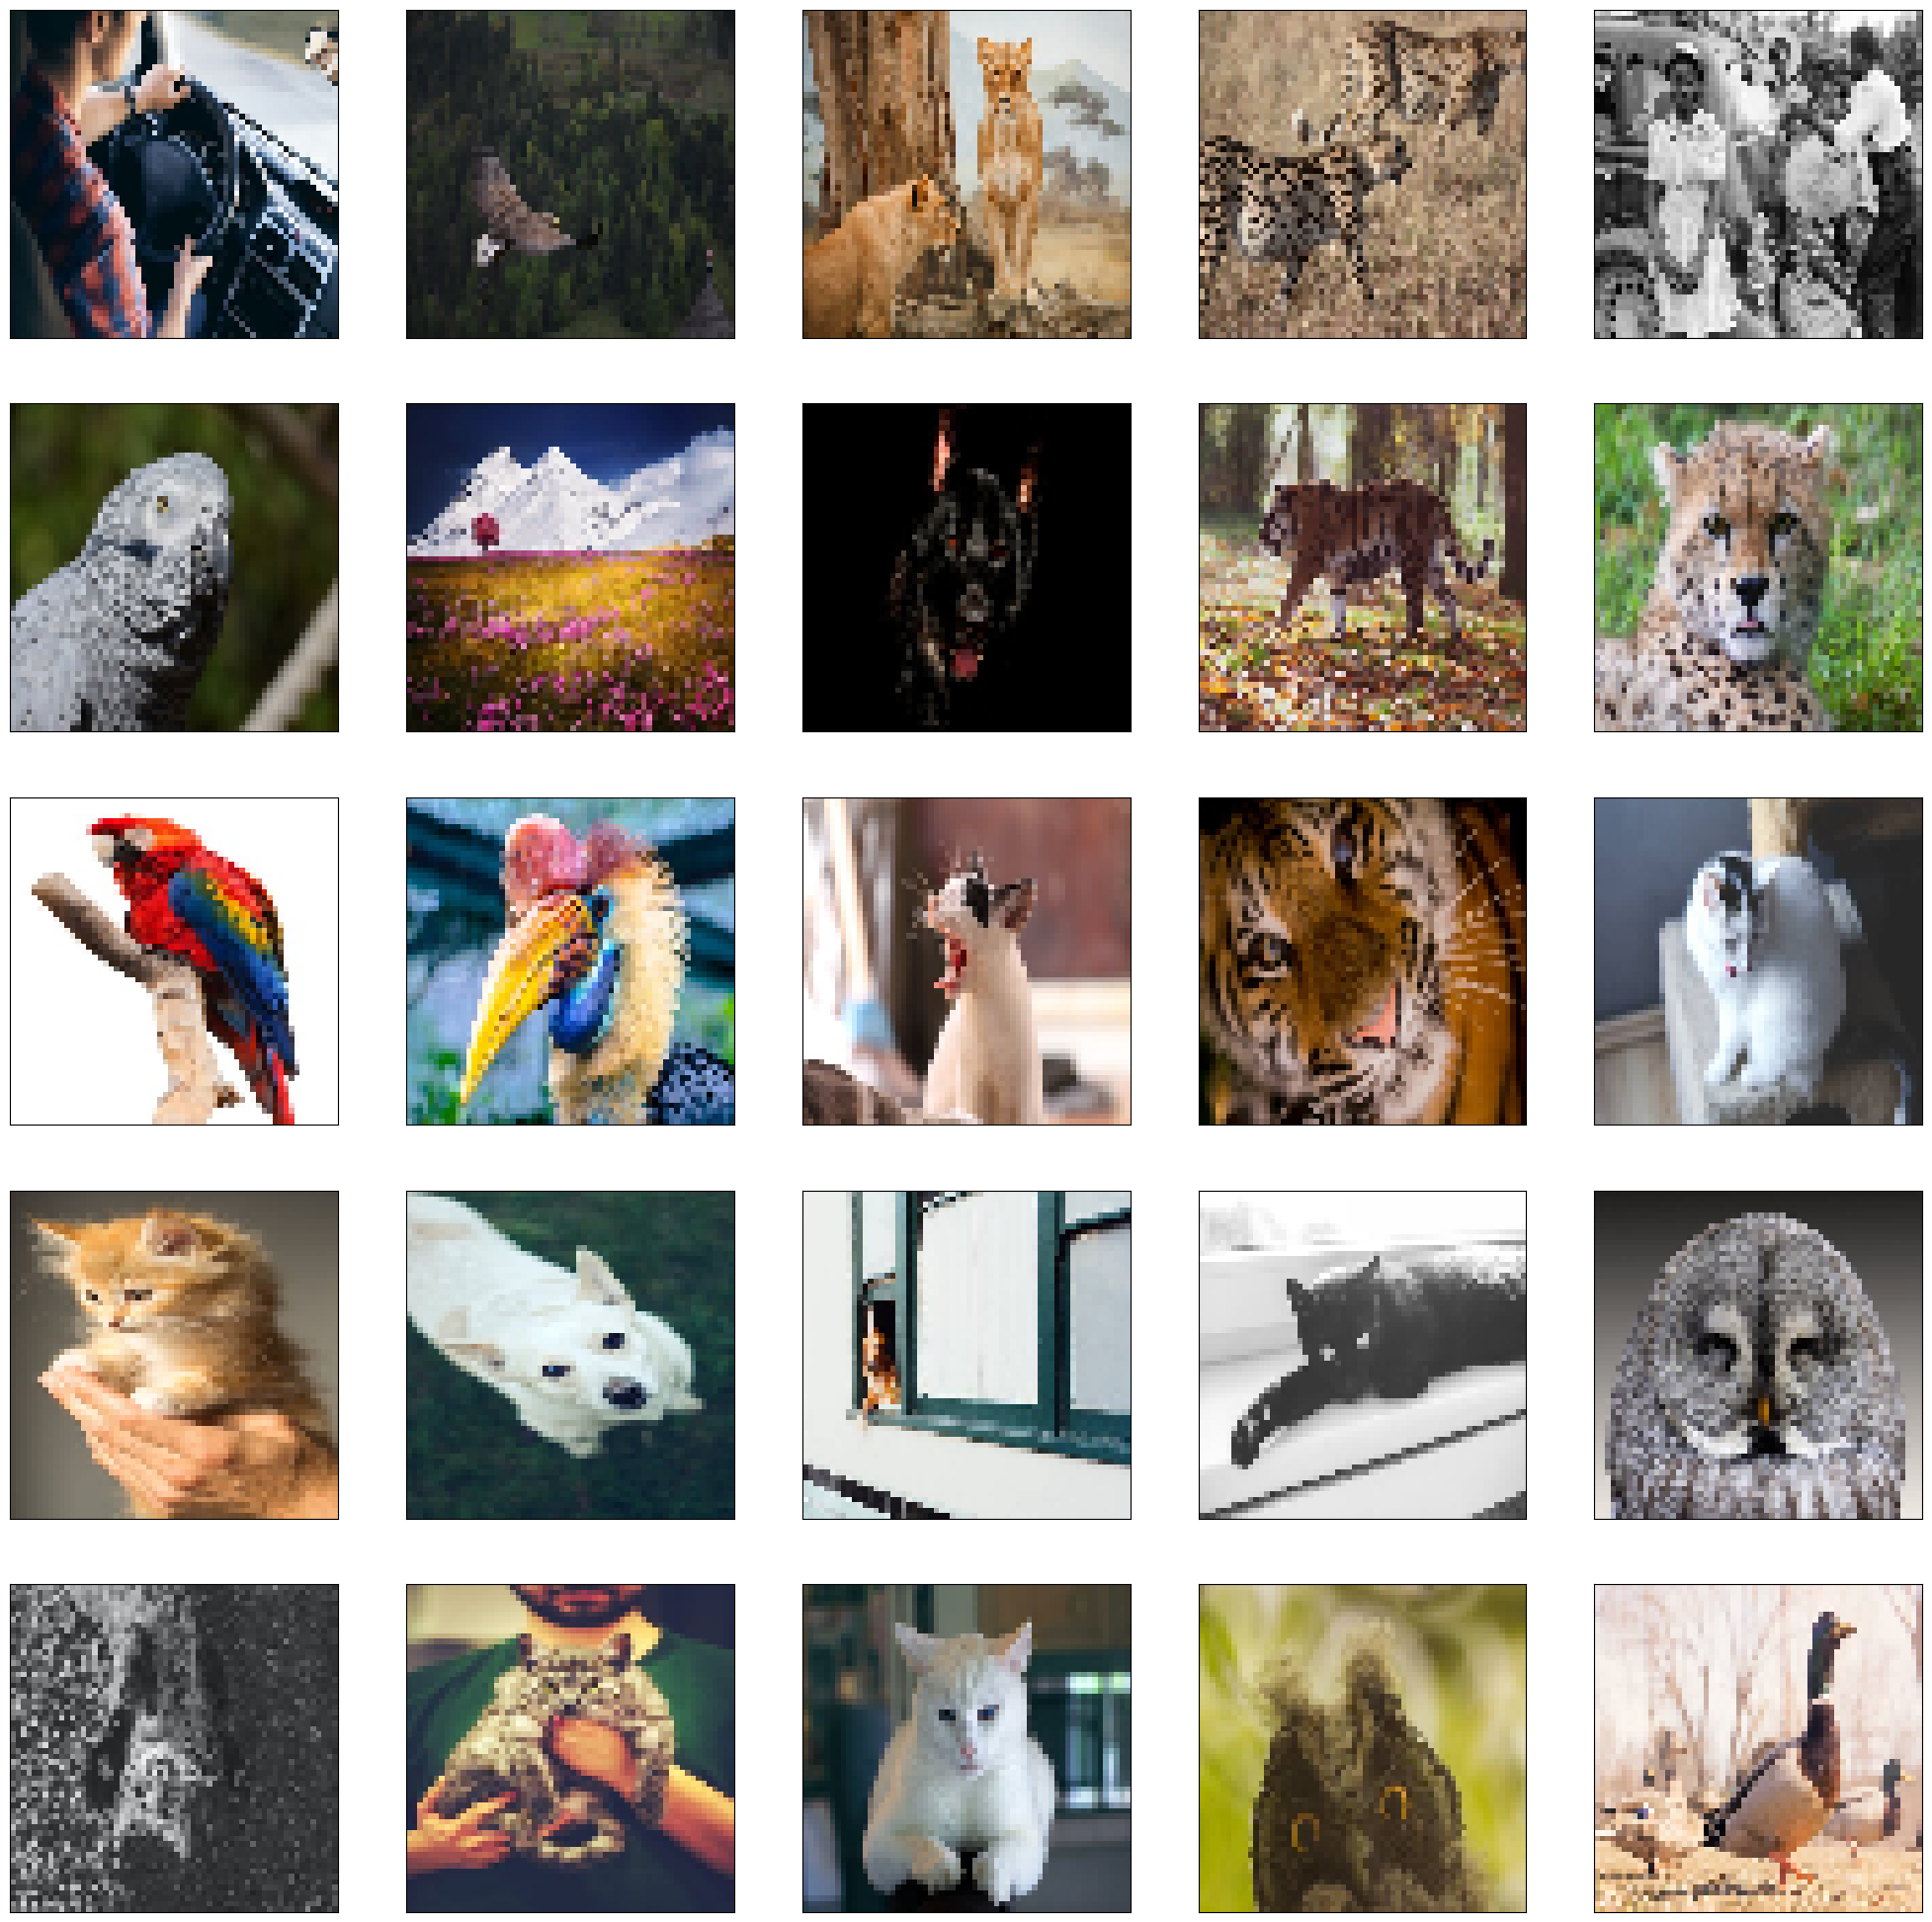

In [ ]:
plt.figure(figsize=(25, 25))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Преобразуем картинку в формат RGB перед выводом
    plt.imshow(cv2.cvtColor(y_train[i], cv2.COLOR_BGR2RGB))
plt.show()

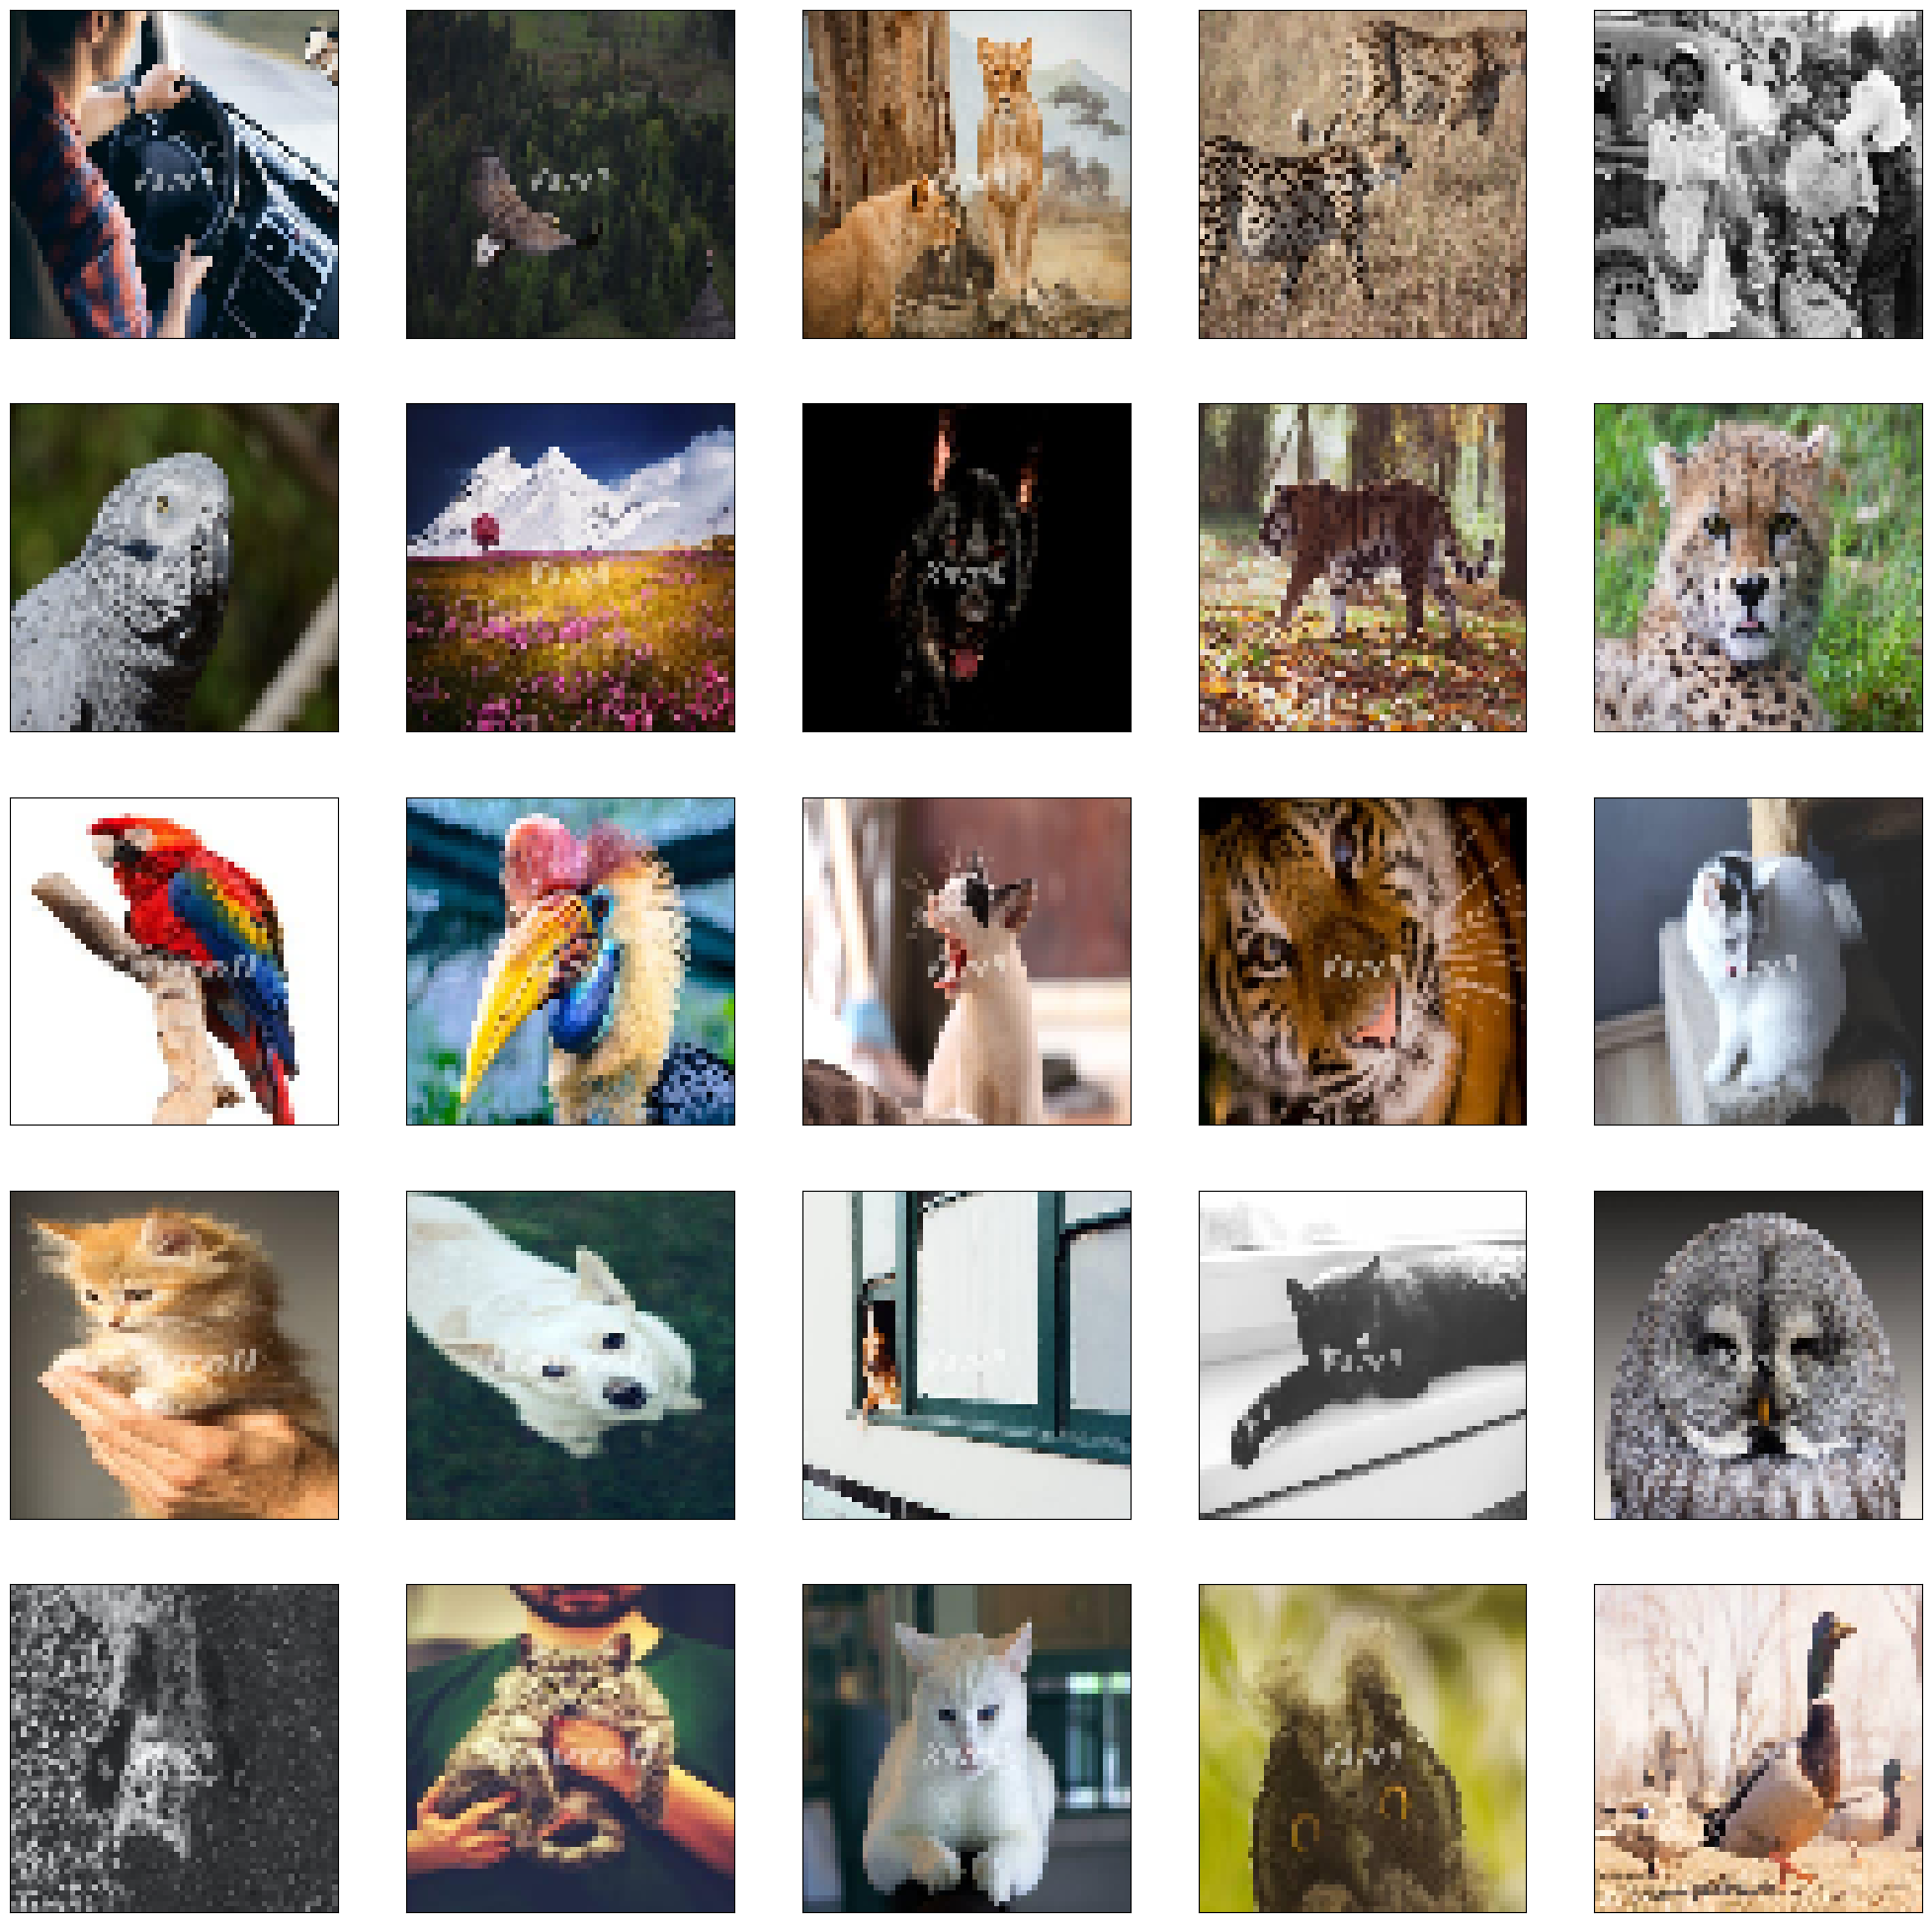

In [ ]:
plt.figure(figsize=(25, 25))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Преобразуем картинку в формат RGB перед выводом
    plt.imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
train_nonwatermarked = None
train_watermarked    = None
valid_nonwatermarked = None
valid_watermarked    = None

In [ ]:
# Функции аугментации изображений

def data_augmentation(inputImage): # функция прогоняет картинки через все методы аугментации
    return randomRotation(randomFlip(randomSaturation(randomContrast(randomBrightness(inputImage))))).numpy()


def randomBrightness(pic): # добавляем изображению случайную яркость от 1% до 20%
    return tf.image.random_brightness(pic, random.uniform(0.01, 0.2), 1)

def randomContrast(pic): # добавляем изображению случайную контрастность от 5% до 50%
    return tf.image.random_contrast(pic, 0.2, 0.7, 1)

def randomSaturation(pic):  # добавляем изображению случайную насыщенность цвета
    return tf.image.random_saturation(pic, 0.3, 0.5, 1)

def randomFlip(pic):  # случайное отражение изображения по горизонтали или вертикали
    flip_horizontal = random.choice([True, False])
    flip_vertical = random.choice([True, False])

    if flip_horizontal:
        pic = tf.image.flip_left_right(pic)
    if flip_vertical:
        pic = tf.image.flip_up_down(pic)
    return pic

def randomRotation(pic):  # случайный поворот изображения на угол от -45 до 45 градусов
    angle = random.uniform(-45, 45)
    image_np = pic.numpy()  # преобразуем тензор в массив NumPy
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8))
    rotated_image = image_pil.rotate(angle, resample=Image.BILINEAR, expand=False)  # поворачиваем
    rotated_image_np = np.array(rotated_image) / 255.0
    return tf.convert_to_tensor(rotated_image_np, dtype=tf.float32)

In [ ]:
data_augmented_X = []
data_augmented_y = []

for image in X_train:
    data_augmented_X.append(data_augmentation(image))

for image in y_train:
    data_augmented_y.append(data_augmentation(image))

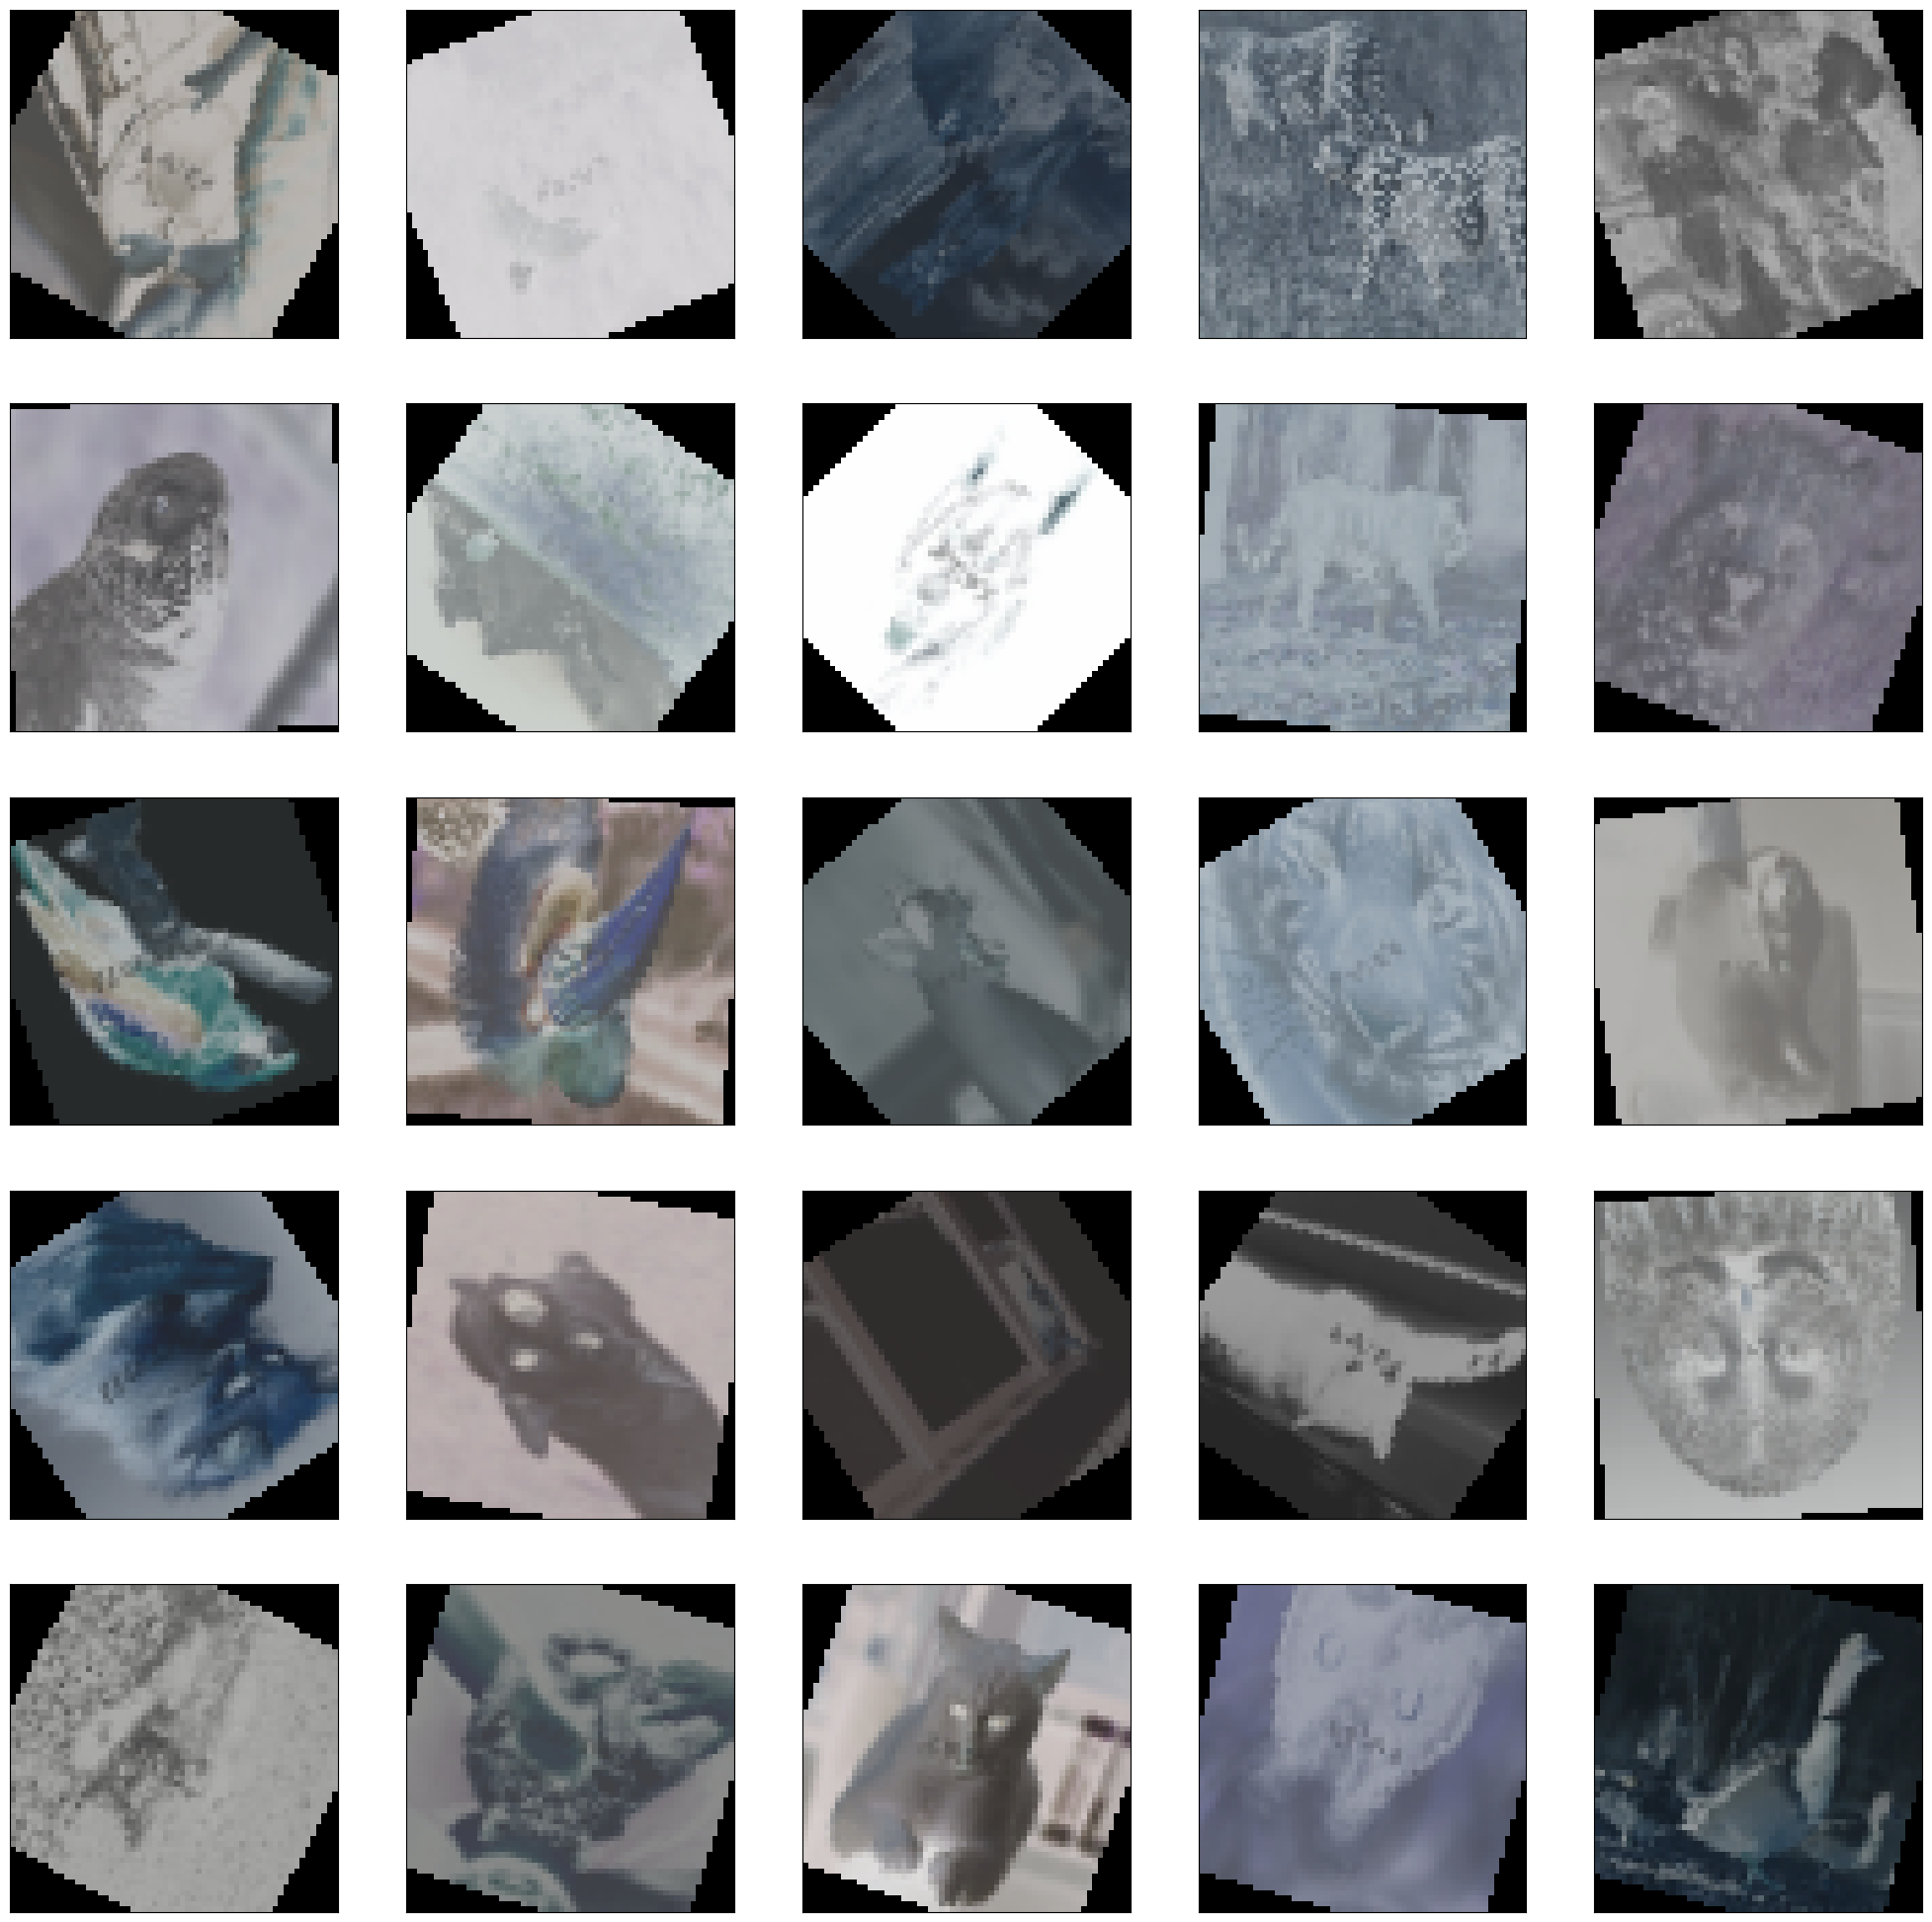

In [ ]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(data_augmented_X[i], cv2.COLOR_BGR2RGB))
plt.show()

**Ахаха, страшно получилось**

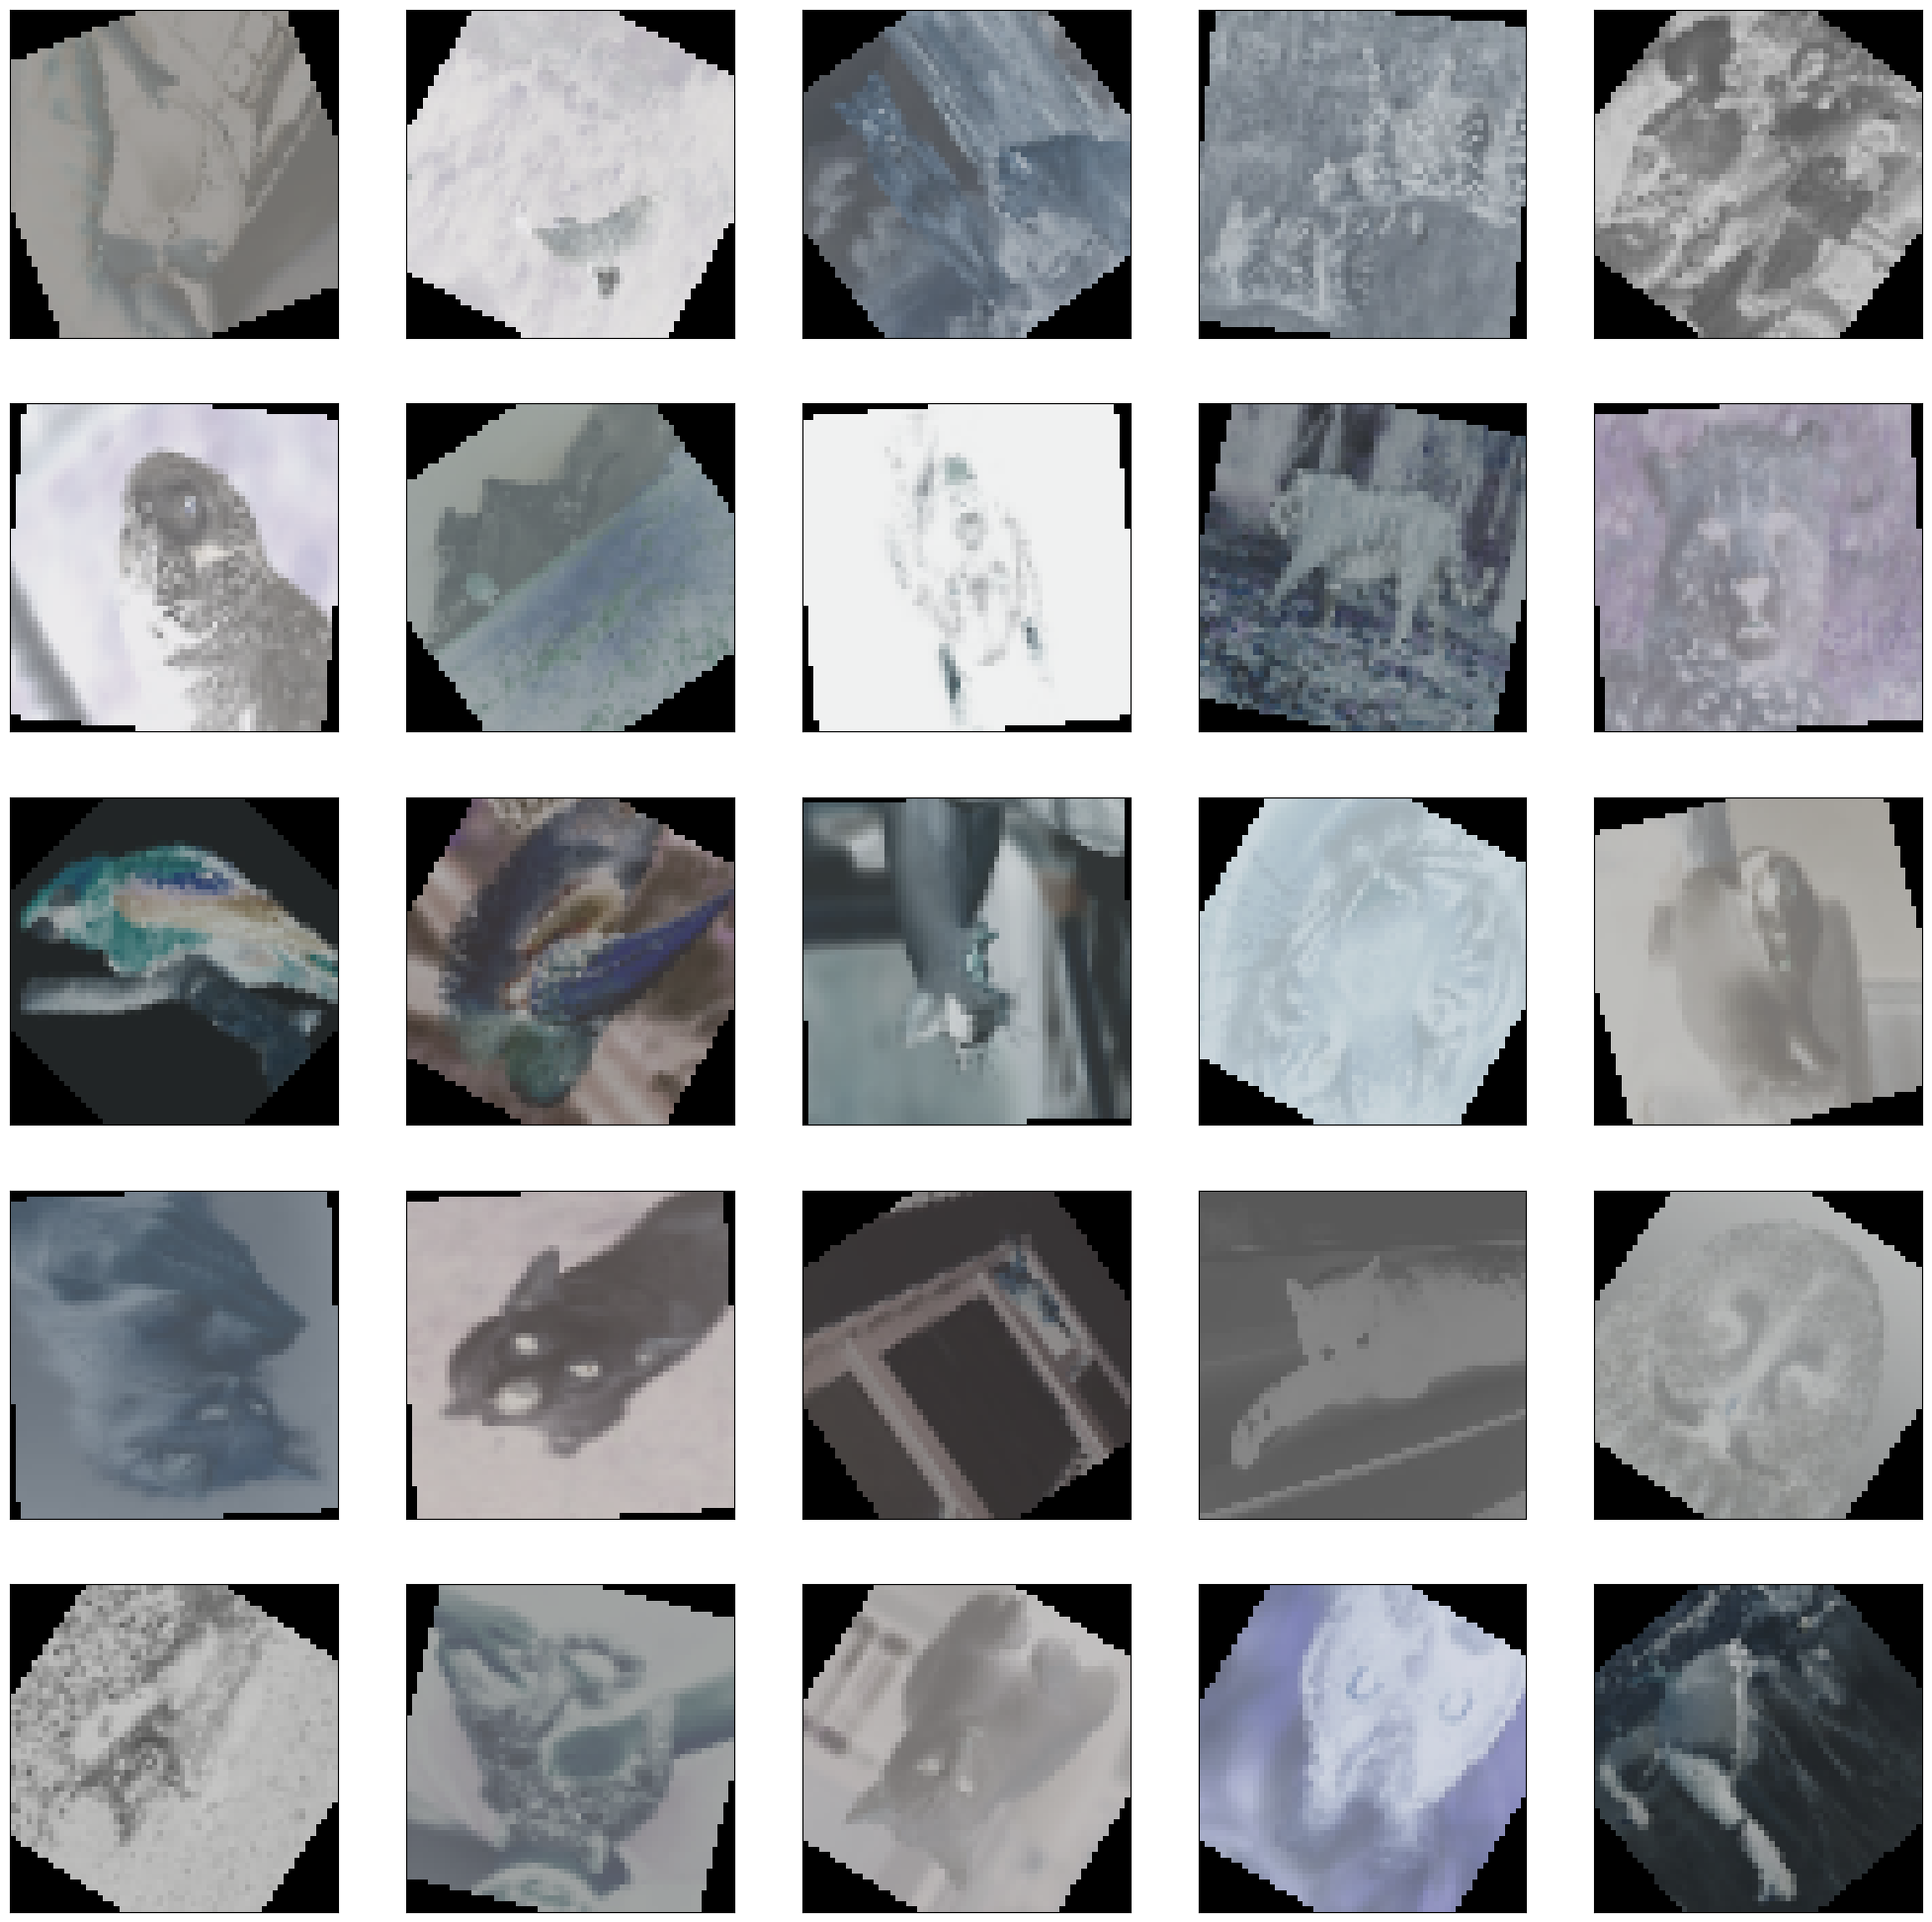

In [ ]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(data_augmented_y[i], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
X_train = np.append(X_train, data_augmented_X, axis=0)
y_train = np.append(y_train, data_augmented_y, axis=0)

In [ ]:
X_train = X_train.astype('float32') / 255.
y_train = y_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

In [ ]:
def create_model(img_x, img_y, channel):
    inputs = Input(shape=(img_x, img_y, channel))
    # немного изменить архитектуру добавив Leakyrelu
    # Кодировщик - сжимает входные данные в латентное пространство
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    h = MaxPooling2D((2, 2), padding='same')(x)

    # Декодировщик - реконструирует сжатое представление
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(h)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2, 2))(x)

    outputs = Conv2D(channel, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse',  metrics=['acc'])
    return model

In [ ]:
watermark_auto_encoder = create_model(width, height, 3)

Схема сверточного автокодировщика:


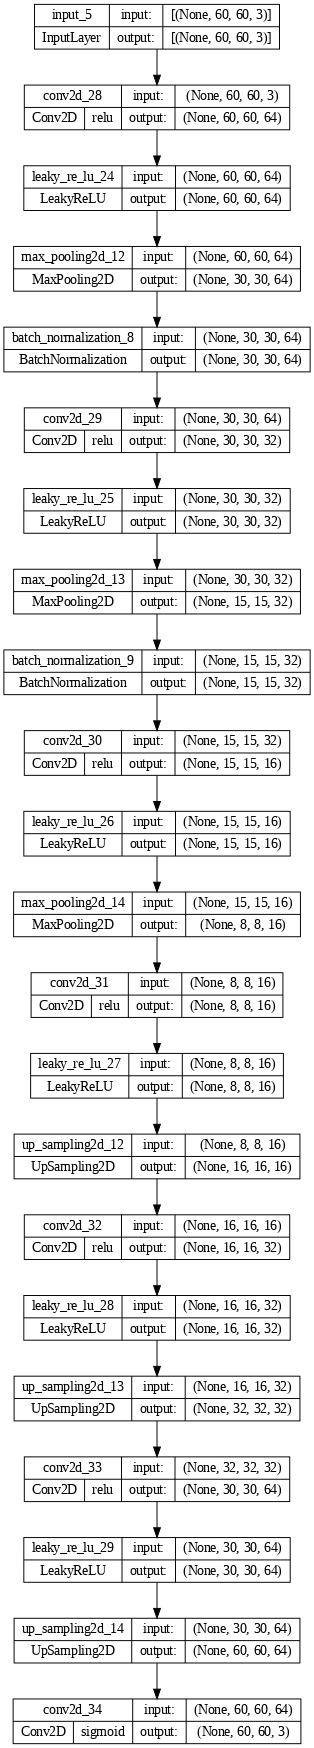

In [ ]:
print('Схема сверточного автокодировщика:')
utils.plot_model(watermark_auto_encoder, show_shapes=True, dpi=70, show_layer_activations=True, expand_nested=True)

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=6, restore_best_weights=True)
history = watermark_auto_encoder.fit(X_train, y_train, batch_size=64, epochs=100, callbacks=[early_stop])

Epoch 1/100
16/16 [==============================] - 19s 1s/step - loss: 0.1487 - acc: 0.3054
Epoch 2/100
16/16 [==============================] - 16s 978ms/step - loss: 0.0789 - acc: 0.2987
Epoch 3/100
16/16 [==============================] - 16s 976ms/step - loss: 0.0364 - acc: 0.2872
Epoch 4/100
16/16 [==============================] - 16s 1s/step - loss: 0.0249 - acc: 0.2905
Epoch 5/100
16/16 [==============================] - 17s 1s/step - loss: 0.0205 - acc: 0.2910
Epoch 6/100
16/16 [==============================] - 16s 1s/step - loss: 0.0192 - acc: 0.2892
Epoch 7/100
16/16 [==============================] - 16s 1s/step - loss: 0.0175 - acc: 0.2963
Epoch 8/100
16/16 [==============================] - 19s 1s/step - loss: 0.0165 - acc: 0.3153
Epoch 9/100
16/16 [==============================] - 16s 989ms/step - loss: 0.0157 - acc: 0.3338
Epoch 10/100
16/16 [==============================] - 16s 996ms/step - loss: 0.0155 - acc: 0.3529
Epoch 11/100
16/16 [===========================

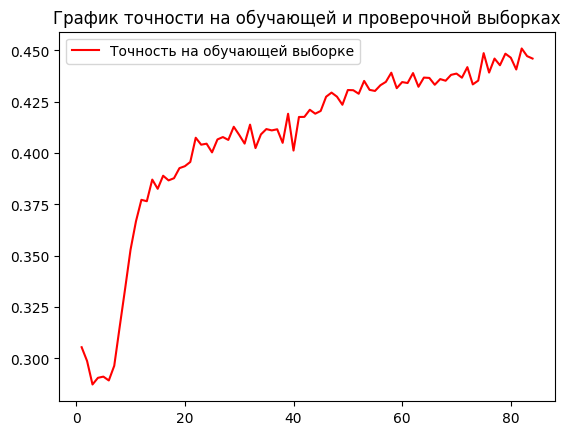

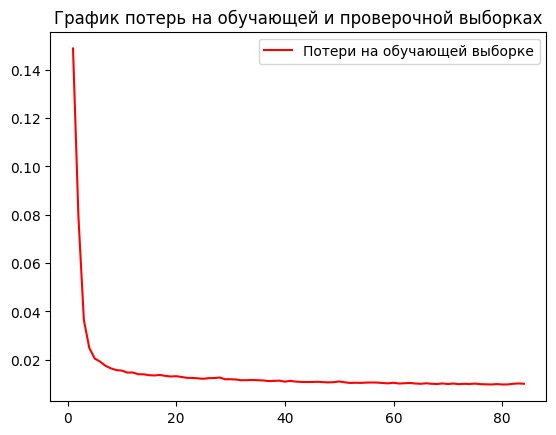

In [ ]:
acc = history.history['acc']              # данные о точности на обучающей выборке
loss = history.history['loss']            # данные об ошибке на обучающей выборке
epochs = range(1, len(acc) + 1)           # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

In [ ]:
result = watermark_auto_encoder.predict(X_test)

16/16 [==============================] - 3s 175ms/step


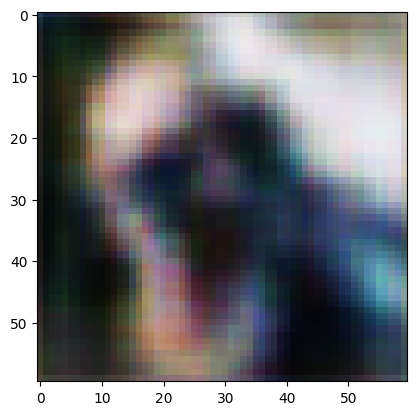

In [ ]:
plt.imshow(cv2.cvtColor(result[0], cv2.COLOR_BGR2RGB))

**Исходные и полученный изображения**

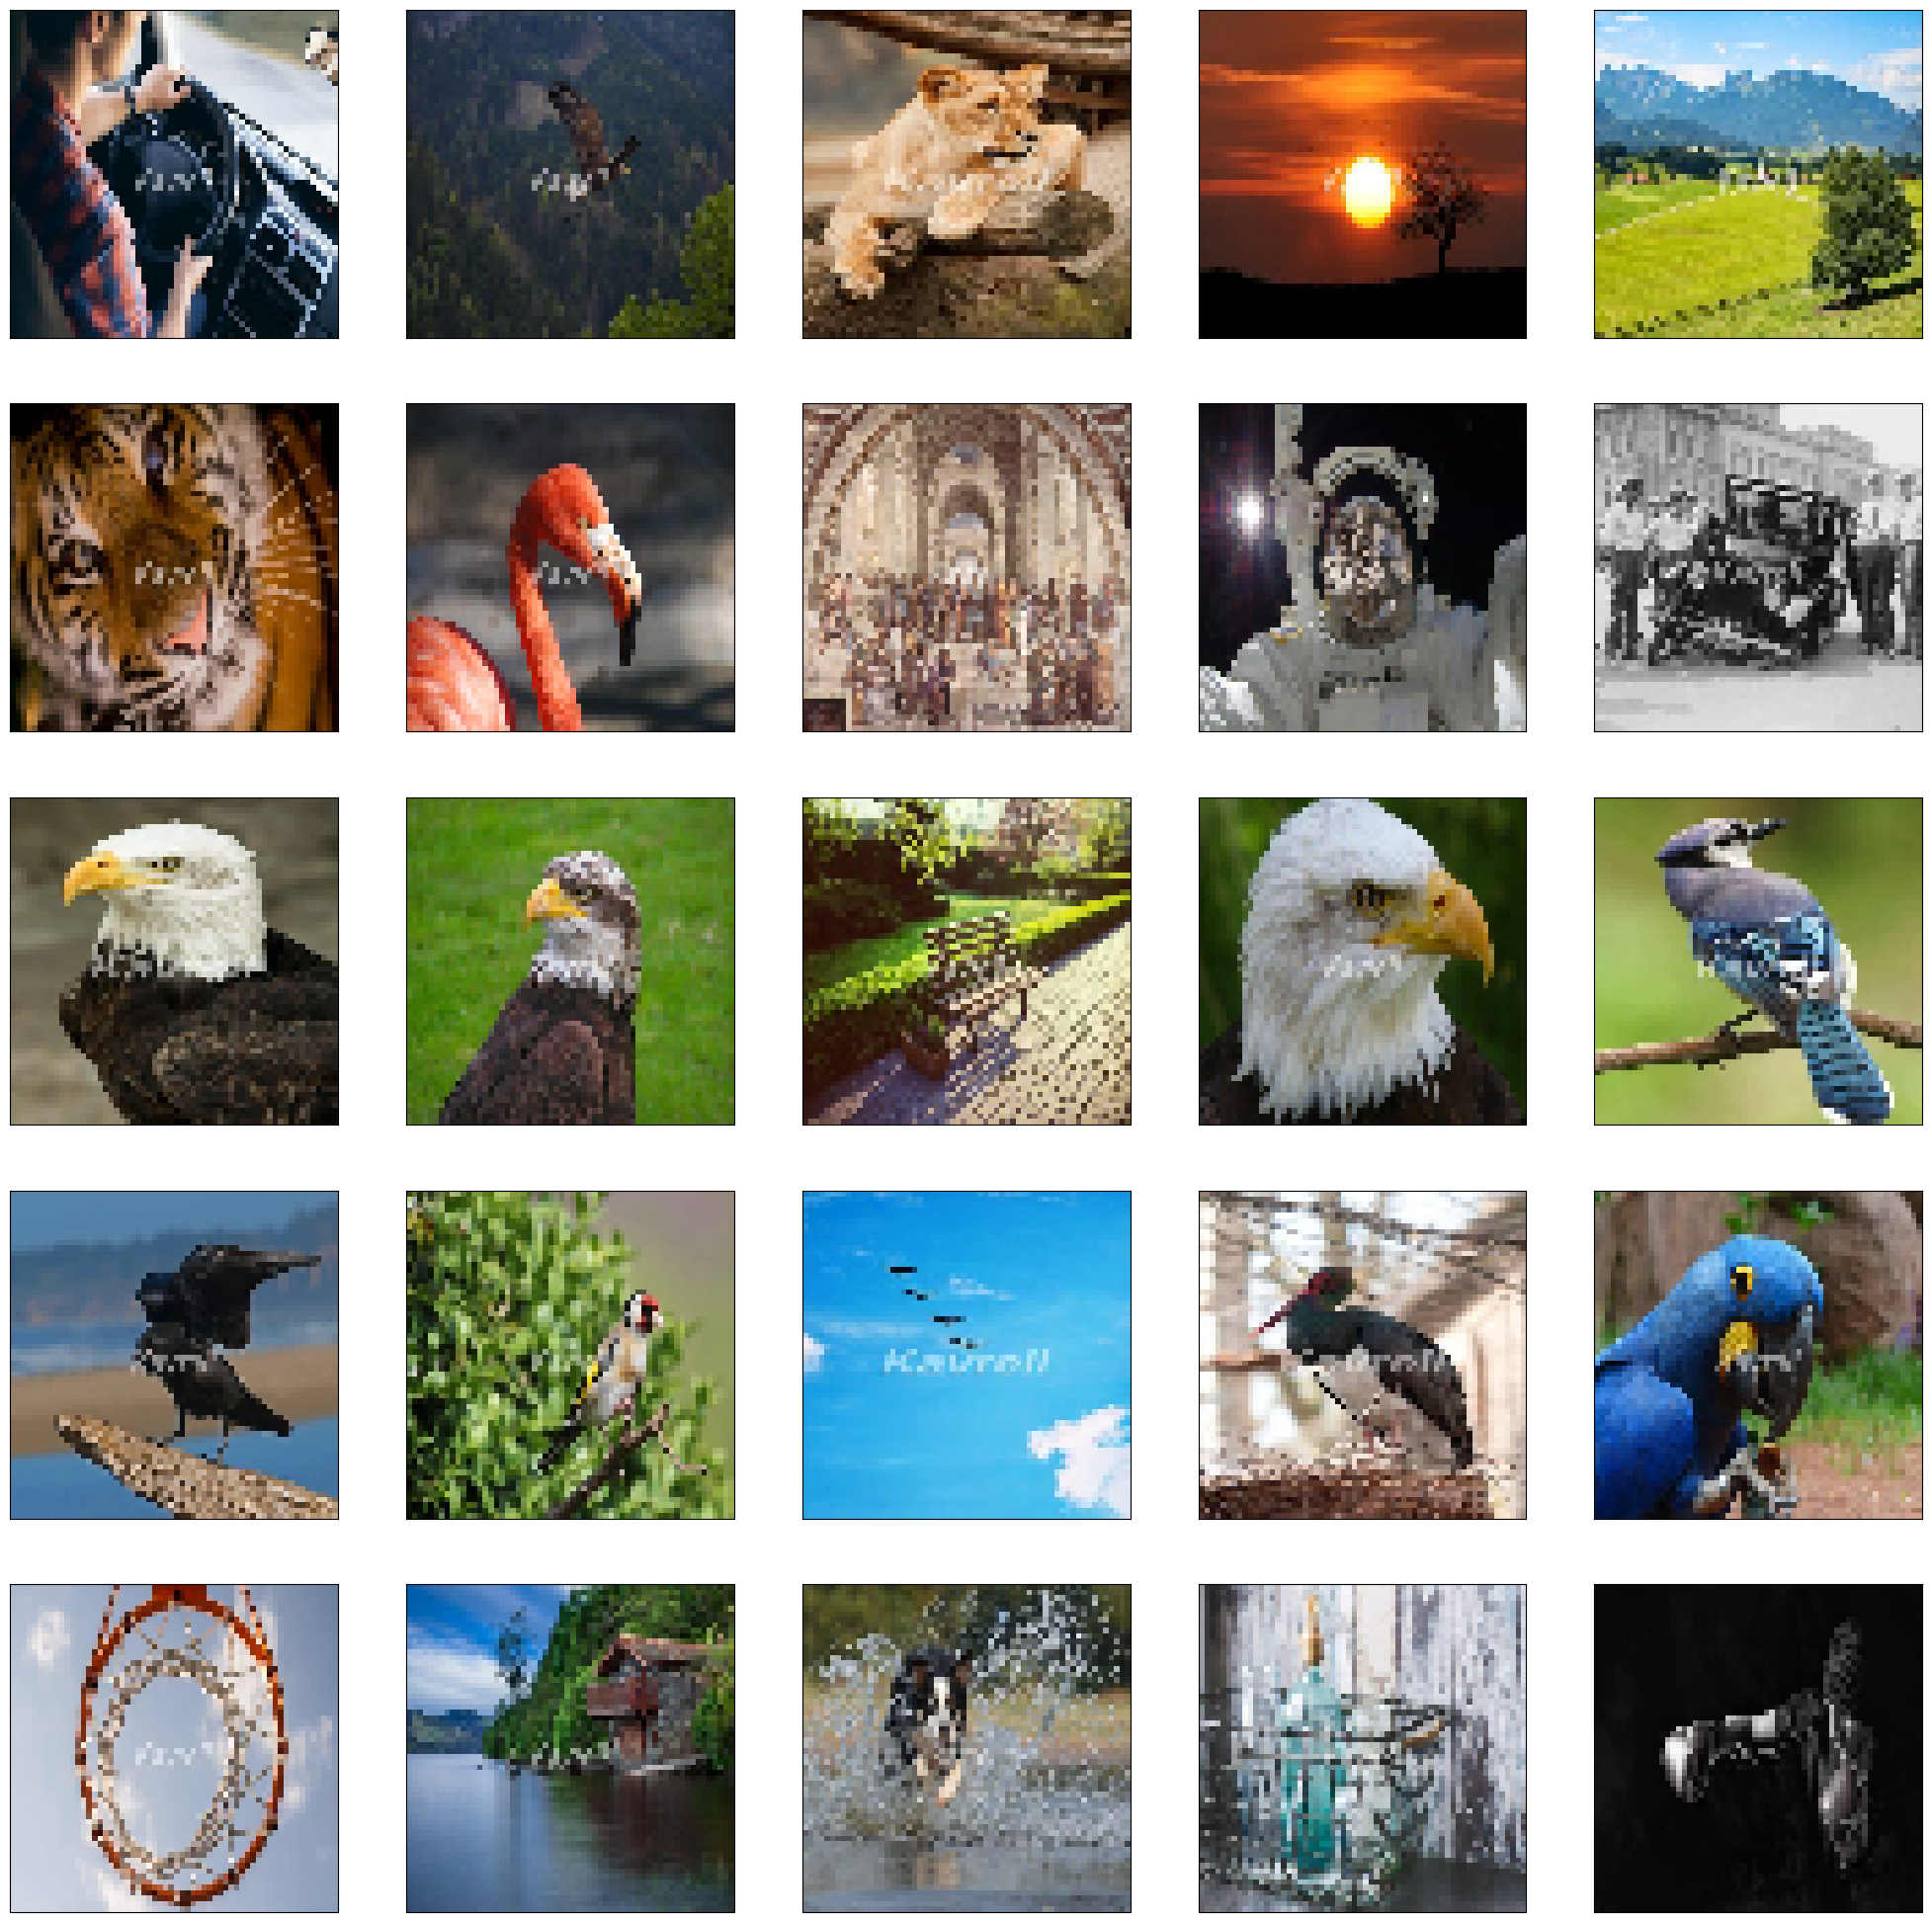

In [ ]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(X_test[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

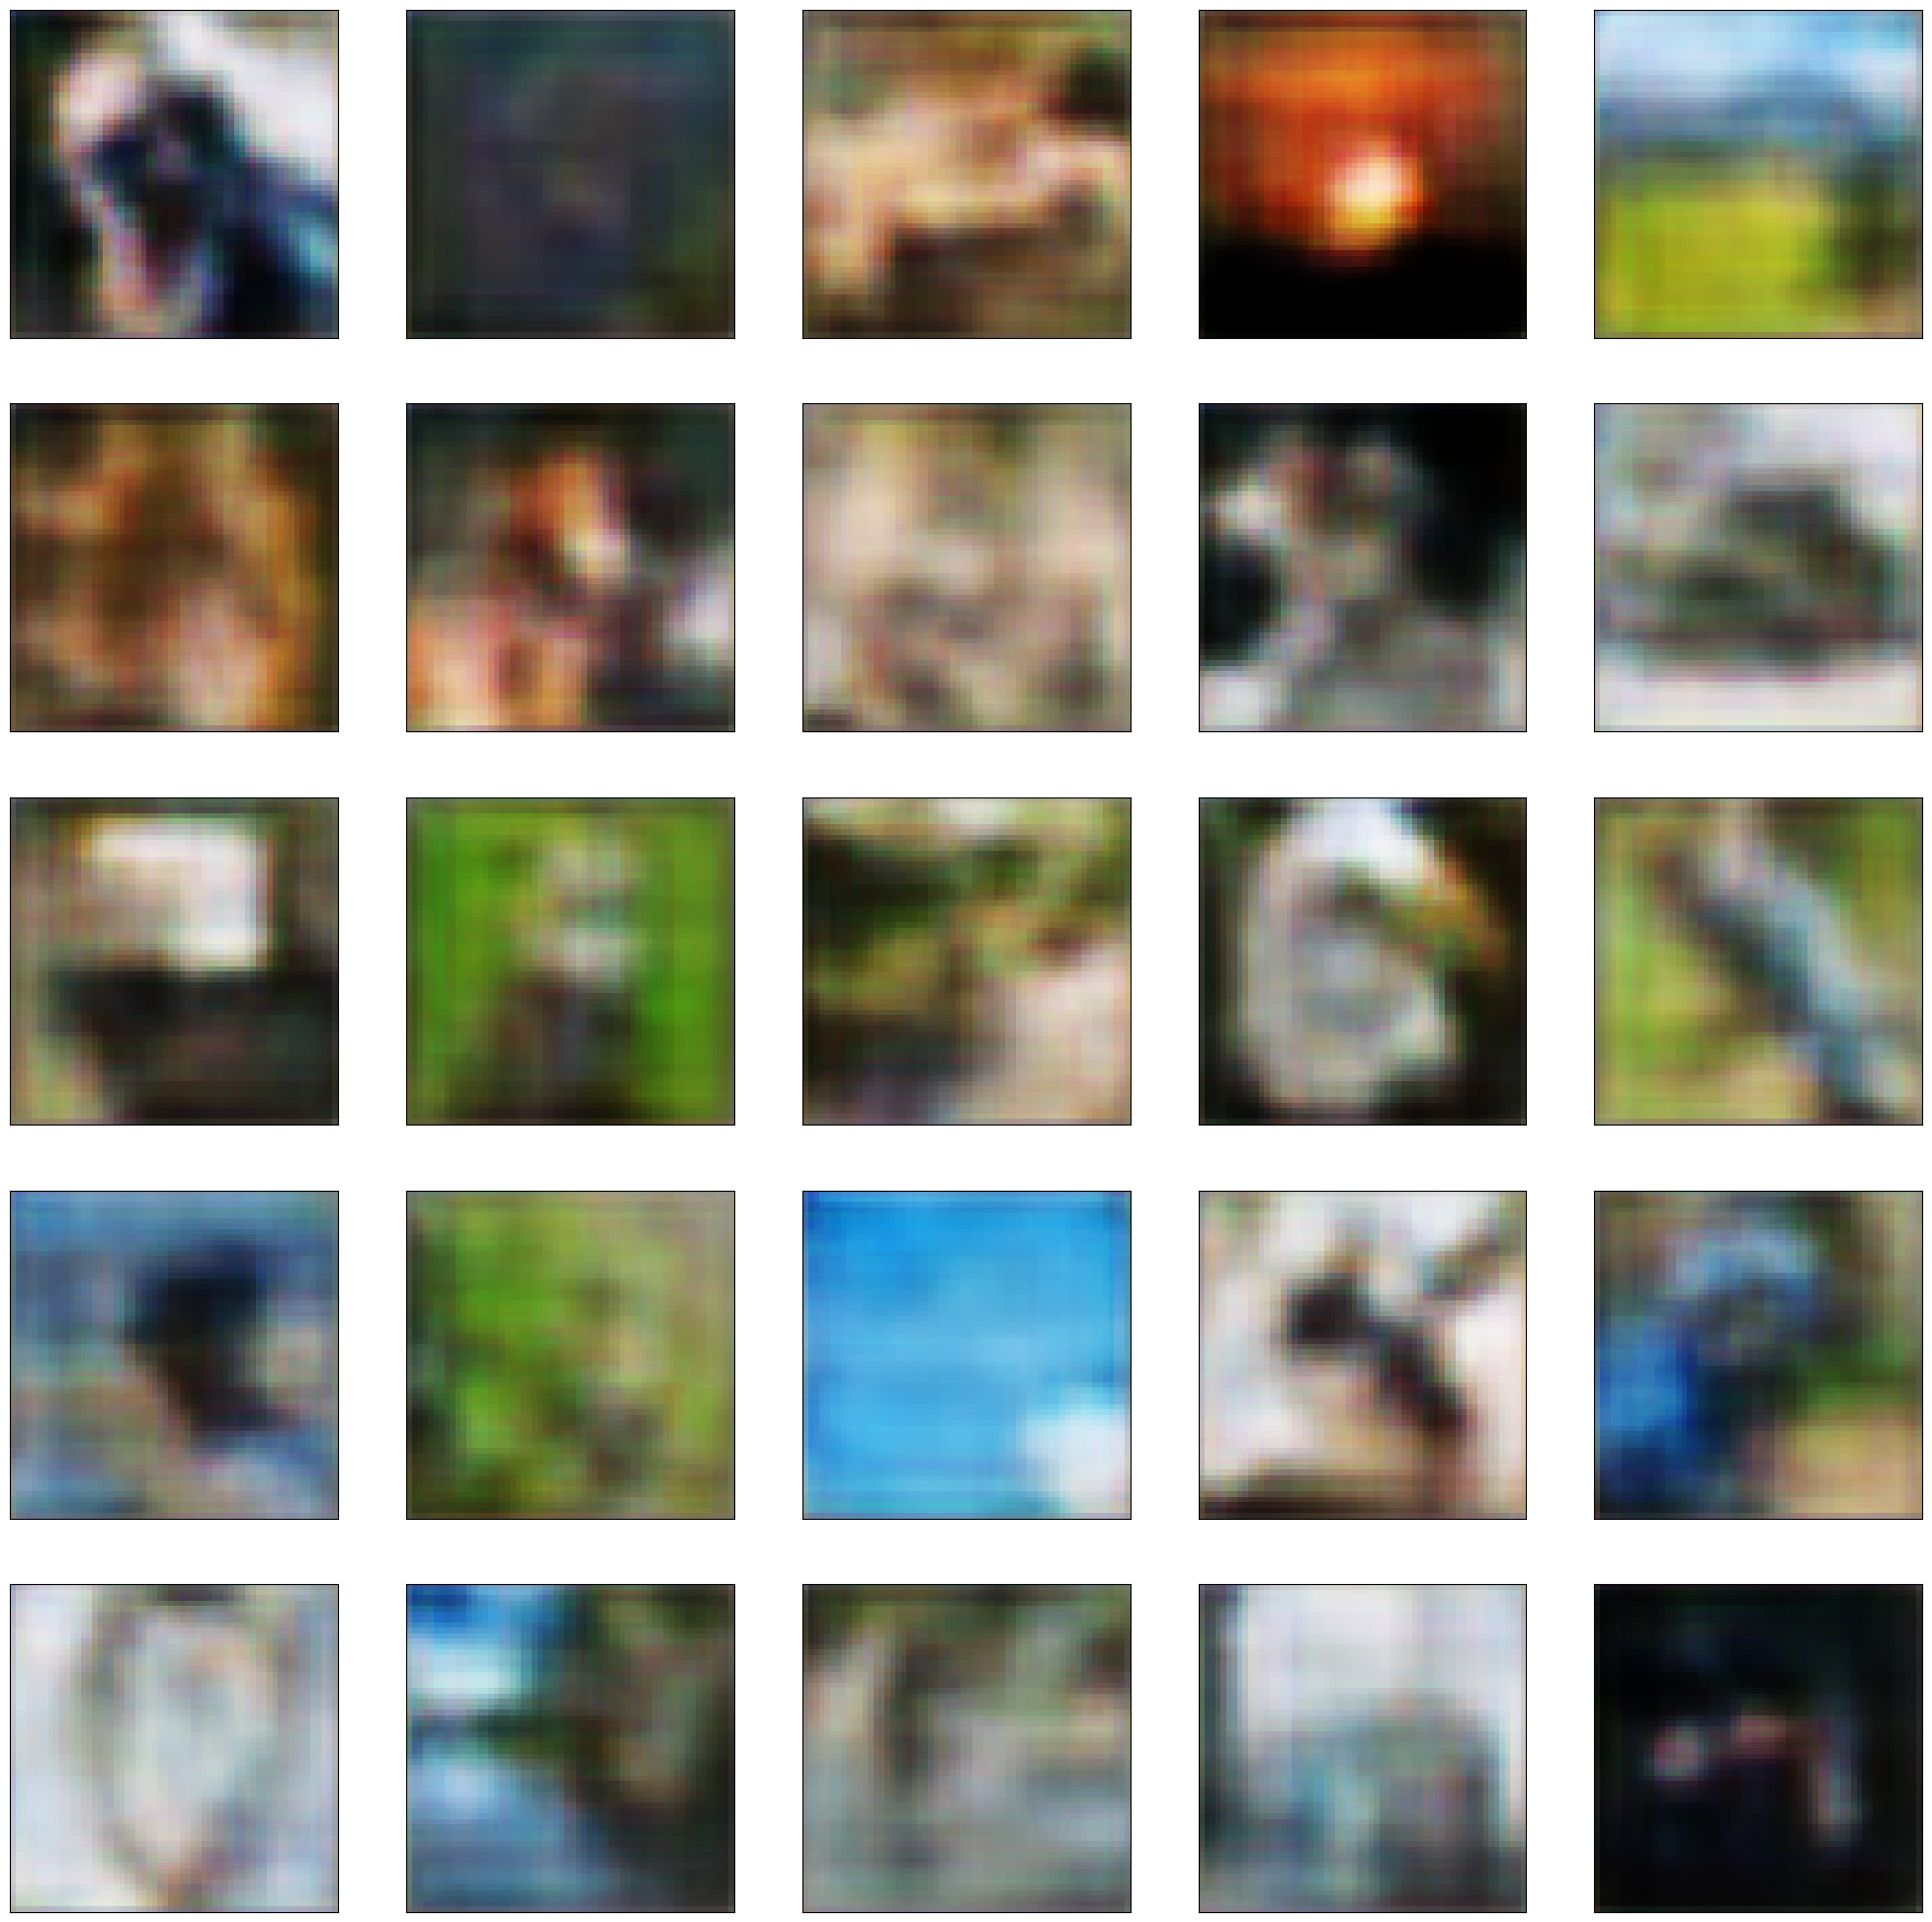

In [ ]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(result[i], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Загрузка исходного изображения
original_image = X_test[0]
predicted_image = result[0]

# Преобразование изображений в массивы NumPy для вычислений
original_array = np.array(original_image)
predicted_array = np.array(predicted_image)

# Вычисление изображения шума (разница между оригиналом и предсказанием)
noise_array = np.abs(original_array - predicted_array)



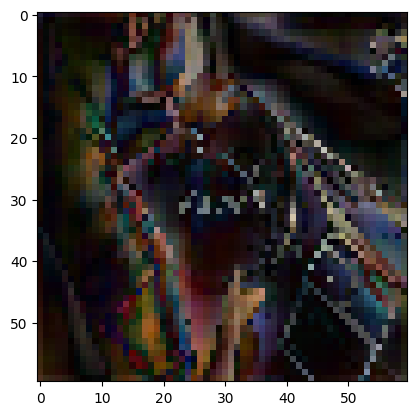

In [ ]:
plt.imshow(cv2.cvtColor(noise_array, cv2.COLOR_BGR2RGB))

**Шум действительно создает очертание первой картинки с автомобилистом =)**

In [ ]:
# Загрузка исходного изображения
original_image = X_test[7]
predicted_image = result[7]

# Преобразование изображений в массивы NumPy для вычислений
original_array = np.array(original_image)
predicted_array = np.array(predicted_image)

# Вычисление изображения шума (разница между оригиналом и предсказанием)
noise_array_1 = np.abs(original_array - predicted_array)

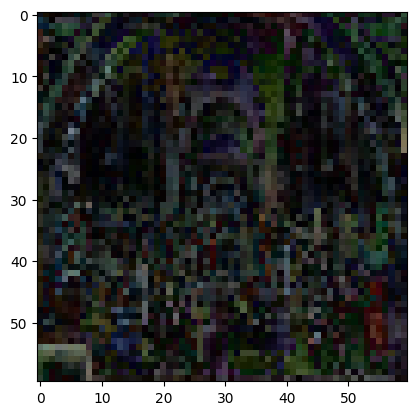

In [ ]:
plt.imshow(cv2.cvtColor(noise_array_1, cv2.COLOR_BGR2RGB))

# **Вывод:**
Можно было бы продолжить выводить 10 изображений как написано в условии, но надо ли?) Алгоритм работает, но есть проблемы:
1) Для получания высокой точности восстановленного изображения, необходимо иметь высокое разрешение оригинальной картинки.
2) Добивить больше фильтров в слои
Однако, есть недостатки при увеличении точности/добавления слоев - это многократно возрастающее время обработки одной эпохи. Пришлось очень сильно сжать изображения, относительно даже тех, что были в изначальном примере, ибо на одну эпоху уходило порядка 2.5-3 минут, что в целом тяжело переносится, когда стоит лимит colab-a по использованию GPU несколько часов. Так что, что есть то есть. В целом, по графику обучения видно, что с каждой последующей эпохой точность возрастает (когда делал изображения 100px+, точность на первых 5 эпохах была около 0.4-0.45) возможно стоило бы сделать 10 эпох и высокое разрешение для картинок, но лимит опять подошел к концу))
Последний пунк из 3 задания выполнить к сожалению не удалсь.